# Laboratorio 8 
    - Francis Aguilar - 22243
    - César López - 22535
    - Gerardo Pineda -22880
    - Angela García -22869 
    - Joaquin Campos - 22155


enlace al repositorio: https://github.com/angelargd8/lab8-deep

# Task 1 - Práctica

In [ ]:
import os, numpy as np, pandas as pd
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

## 1. Preparacion de datos

In [4]:
tf.random.set_seed(42)

df = pd.read_csv("data/train.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["store", "item", "date"]).reset_index(drop=True)

df["sales"] = pd.to_numeric(df["sales"], errors="coerce").fillna(0)

def _clip(g):
    lo, hi = g["sales"].quantile([0.01, 0.99]).values
    g["sales"] = g["sales"].clip(lo, hi)
    return g
df = df.groupby(["store","item"], group_keys=False).apply(_clip)


if df["date"].dt.to_period("M").nunique() < df["date"].nunique():
    df["ym"] = df["date"].dt.to_period("M").dt.to_timestamp()
    df = (df.groupby(["store","item","ym"], as_index=False)["sales"].sum()
            .rename(columns={"ym":"date"}))

all_months = pd.DataFrame({"date": pd.date_range(df["date"].min(), df["date"].max(), freq="MS")})
pairs = df[["store","item"]].drop_duplicates()
panel = pairs.merge(all_months, how="cross")
df = (panel.merge(df, on=["store","item","date"], how="left")
           .sort_values(["store","item","date"])
           .reset_index(drop=True))
df["sales"] = df["sales"].fillna(0.0)

df

C:\Users\jjcam\AppData\Local\Temp\ipykernel_31100\3001687787.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["store","item"], group_keys=False).apply(_clip)


,store,item,date,sales
0,1,1,2013-01-01,331.0
1,1,1,2013-02-01,322.0
2,1,1,2013-03-01,477.0
3,1,1,2013-04-01,522.0
4,1,1,2013-05-01,531.0
...,...,...,...,...
29995,10,50,2017-08-01,2866.0
29996,10,50,2017-09-01,2586.0
29997,10,50,2017-10-01,2507.0
29998,10,50,2017-11-01,2574.0


## 2.Preprocesamiento de datos

In [5]:
HIST = 18   # meses de historia por ventana
HORIZON = 3 # meses a predecir
months = df["date"].sort_values().drop_duplicates().to_numpy()
test_months = months[-HORIZON:]             # últimos 3 meses -> test
val_months  = months[-(HORIZON*2): -HORIZON]      # 3 meses previos -> val
train_months= months[:-(HORIZON*2)]

In [6]:
def make_sequences(group_df, hist=18, horizon=-3, scaler=None):
    g = group_df.sort_values("date").copy()
    sales = g["sales"].values.reshape(-1,1)
    s_sc = scaler.transform(sales)

    X, y, dates_end = [], [], []
    for end in range(hist, len(s_sc) - horizon + 1):
        X.append(s_sc[end-hist:end, :])     
        y.append(s_sc[end:end+horizon, 0])
        dates_end.append(g["date"].iloc[end+horizon-1])
    return np.array(X), np.array(y), np.array(dates_end)

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
pairs_index_test = []   

for (store, item), g in df.groupby(["store","item"]):
    g = g.sort_values("date").reset_index(drop=True)

    # necesitamos mínimo hist+horizon meses en train para ajustar el scaler de forma robusta
    g_train = g[g["date"].isin(train_months)].copy()
    if len(g_train) < HIST + HORIZON:
        continue

    scaler = RobustScaler(quantile_range=(5,95))
    scaler.fit(g_train[["sales"]].values)

    X_all, y_all, dates_end = make_sequences(g, HIST, HORIZON, scaler)

    for Xi, yi, d_end in zip(X_all, y_all, dates_end):
        if d_end in test_months:
            X_test.append(Xi); y_test.append(yi); pairs_index_test.append((store,item,d_end))
        elif d_end in val_months:
            X_val.append(Xi);  y_val.append(yi)
        elif d_end in train_months:
            X_train.append(Xi); y_train.append(yi)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val,   y_val   = np.array(X_val),   np.array(y_val)
X_test,  y_test  = np.array(X_test),  np.array(y_test)

print("Shapes ->",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_val",   X_val.shape,   "y_val",   y_val.shape,
      "X_test",  X_test.shape,  "y_test",  y_test.shape)

Shapes -> X_train (17000, 18, 1) y_train (17000, 3) X_val (1500, 18, 1) y_val (1500, 3) X_test (1500, 18, 1) y_test (1500, 3)


## 3 y 4  Seleccion de modelo y arquitectura

In [7]:
LR = 1e-3
model = models.Sequential([
    layers.Input(shape=(HIST, 1)),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(HORIZON)
])
model.compile(
    loss="mse",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,251 (83.01 KB)

 Trainable params: 21,251 (83.01 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenamiento con EarlyStopping

In [8]:
BATCH = 256
EPOCHS = 200

In [9]:
es  = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0730 - mae: 0.2211 - val_loss: 0.0170 - val_mae: 0.0957 - learning_rate: 0.0010
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0173 - mae: 0.1040 - val_loss: 0.0110 - val_mae: 0.0794 - learning_rate: 0.0010
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0135 - mae: 0.0924 - val_loss: 0.0082 - val_mae: 0.0705 - learning_rate: 0.0010
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0117 - mae: 0.0855 - val_loss: 0.0075 - val_mae: 0.0682 - learning_rate: 0.0010
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0106 - mae: 0.0815 - val_loss: 0.0072 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0100 - mae: 0.0792 - val_loss: 0.0062 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0094 - mae: 0.0765 - val_loss: 0.0064 - val_mae: 0.0635 - learning_rate: 0.0010
Epoch 

## 6. Evaluación del modelo 

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

# Evaluación directa con Keras
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss (MSE): {test_loss:.4f}")
print(f"MAE: {test_mae:.4f}")

# Predicciones sobre el conjunto de test
y_pred = model.predict(X_test)

# Cálculo de métricas adicionales
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de evaluación:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R² = {r2:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mae: 0.0441
Loss (MSE): 0.0034
MAE: 0.0449
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Métricas de evaluación:
MAE  = 0.0449
MSE  = 0.0034
RMSE = 0.0581
R² = 0.6700


Los resultados del modelo indican un desempeño bastante bueno en términos de error absoluto y cuadrático: la **MAE de 0.0536** sugiere que, en promedio, las predicciones se desvían aproximadamente 0.054 unidades de los valores reales, mientras que el **RMSE de 0.0678** confirma que los errores más grandes no son excesivos, mostrando una distribución de errores relativamente uniforme. La **MSE de 0.0046** respalda esta observación al reflejar un error cuadrático pequeño. Sin embargo, el **R² de 0.5155** indica que el modelo explica alrededor del 51% de la variabilidad de los datos, lo que significa que aún existe una parte considerable de la variación que no se captura. En conjunto, el modelo predice con precisión moderada, con errores bajos, pero podría mejorar en la capacidad de capturar toda la dinámica de los datos. También puede ser indice de sobreajuste


## 7. Ajuste de hiperparámetros

In [11]:
def build_lstm_model(units=64, stacked=False, dropout=0.0, dense_units=64, lr=1e-3, output_size=None):
    if output_size is None:
        output_size = HORIZON

    m = models.Sequential()
    m.add(layers.Input(shape=(HIST, 1)))

    if stacked:
        m.add(layers.LSTM(units, return_sequences=True))
        if dropout > 0:
            m.add(layers.Dropout(dropout))
        m.add(layers.LSTM(units))
    else:
        m.add(layers.LSTM(units))

    if dropout > 0:
        m.add(layers.Dropout(dropout))

    if dense_units and dense_units > 0:
        m.add(layers.Dense(dense_units, activation="relu"))

    m.add(layers.Dense(output_size, activation="linear"))

    opt = optimizers.Adam(learning_rate=lr)
    m.compile(optimizer=opt, loss="mse")
    return m

In [12]:
import itertools, time

param_grid = {
    "units": [32, 64, 128],
    "stacked": [False, True],
    "dropout": [0.0, 0.2, 0.4],
    "dense_units": [64, 128],
    "lr": [1e-3, 5e-4],
    "batch": [128, 256],
    "epochs": [60],
}

keys = list(param_grid.keys())
combos = list(itertools.product(*[param_grid[k] for k in keys]))

results = []
print(f"Probando {len(combos)} combinaciones...")

best = {"val_loss": np.inf, "combo": None, "hist": None}

for i, combo in enumerate(combos, 1):
    params = dict(zip(keys, combo))
    print(f"\n[{i}/{len(combos)}] {params}")

    model = build_lstm_model(
        units=params["units"],
        stacked=params["stacked"],
        dropout=params["dropout"],
        dense_units=params["dense_units"],
        lr=params["lr"],
    )

    t0 = time.time()
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params["epochs"],
        batch_size=params["batch"],
        callbacks=[es, rlr],
        verbose=0
    )
    dt = time.time() - t0

    val_loss = float(min(hist.history["val_loss"]))
    train_loss = float(min(hist.history["loss"]))
    results.append({
        **params,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "time_s": round(dt, 2)
    })

    if val_loss < best["val_loss"]:
        best = {"val_loss": val_loss, "combo": params, "hist": hist.history}

# DataFrame con ranking de combinaciones
hp_results = pd.DataFrame(results).sort_values("val_loss", ascending=True).reset_index(drop=True)
display(hp_results.head(10)) 

print("\nMejor combinación encontrada:")
print(best["combo"])
print(f"Mejor val_loss: {best['val_loss']:.6f}")


Probando 144 combinaciones...

[1/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 64, 'lr': 0.001, 'batch': 128, 'epochs': 60}

[2/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 64, 'lr': 0.001, 'batch': 256, 'epochs': 60}

[3/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 64, 'lr': 0.0005, 'batch': 128, 'epochs': 60}

[4/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 64, 'lr': 0.0005, 'batch': 256, 'epochs': 60}

[5/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 128, 'lr': 0.001, 'batch': 128, 'epochs': 60}

[6/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 128, 'lr': 0.001, 'batch': 256, 'epochs': 60}

[7/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 128, 'lr': 0.0005, 'batch': 128, 'epochs': 60}

[8/144] {'units': 32, 'stacked': False, 'dropout': 0.0, 'dense_units': 128, 'lr': 0.0005, 'batch': 256, 'epochs': 60}

[9/144] {'units': 32, 'st

,units,stacked,dropout,dense_units,lr,batch,epochs,train_loss,val_loss,time_s
0,128,True,0.2,64,0.0010,128,60,0.002385,0.002773,351.11
1,128,True,0.2,128,0.0010,128,60,0.002372,0.002819,279.12
2,32,True,0.2,64,0.0010,128,60,0.002928,0.002857,63.12
3,64,False,0.0,128,0.0005,128,60,0.002186,0.002870,59.94
4,64,True,0.0,128,0.0005,256,60,0.002200,0.002921,129.08
5,128,True,0.0,64,0.0010,128,60,0.002141,0.002925,234.76
6,128,True,0.4,128,0.0010,128,60,0.002560,0.002932,389.95
7,32,True,0.0,128,0.0005,128,60,0.002215,0.002933,54.50
8,32,False,0.4,64,0.0010,256,60,0.004085,0.002954,21.39
9,128,True,0.0,128,0.0010,256,60,0.002128,0.002956,271.56



Mejor combinación encontrada:
{'units': 128, 'stacked': True, 'dropout': 0.2, 'dense_units': 64, 'lr': 0.001, 'batch': 128, 'epochs': 60}
Mejor val_loss: 0.002773


## 8. Forecasting

In [13]:
assert 'hp_results' in globals() and len(hp_results) > 0, "Primero ejecuta la celda de ajuste de hiperparámetros."
assert 'build_lstm_model' in globals(), "No se encontró build_lstm_model (defínela en la celda del ajuste)."

best_params = hp_results.iloc[0][["units","stacked","dropout","dense_units","lr","batch","epochs"]].to_dict()
print("Entrenando modelo final con mejores hiperparámetros:\n", best_params)

X_tr_full = np.concatenate([X_train, X_val], axis=0)
y_tr_full = np.concatenate([y_train, y_val], axis=0)

final_model = build_lstm_model(
    units=int(best_params["units"]),
    stacked=bool(best_params["stacked"]),
    dropout=float(best_params["dropout"]),
    dense_units=int(best_params["dense_units"]),
    lr=float(best_params["lr"]),
    output_size=HORIZON
)

final_model.fit(
    X_tr_full, y_tr_full,
    epochs=int(best_params["epochs"]),
    batch_size=int(best_params["batch"]),
    verbose=1
)

y_pred_test = final_model.predict(X_test, verbose=0)

# DataFrame con columnas por mes pronosticado
cols_pred = [f"y_pred_t+{i+1}" for i in range(HORIZON)]
forecast_df = pd.DataFrame(y_pred_test, columns=cols_pred)

if 'y_test' in globals() and y_test is not None and getattr(y_test, "ndim", 1) == 2 and y_test.shape[1] == HORIZON:
    for i in range(HORIZON):
        forecast_df[f"y_true_t+{i+1}"] = y_test[:, i]

print("\nMuestra de pronósticos (multistep):")
display(forecast_df.head(10))


Entrenando modelo final con mejores hiperparámetros:
 {'units': 128, 'stacked': True, 'dropout': 0.2, 'dense_units': 64, 'lr': 0.001, 'batch': 128, 'epochs': 60}
Epoch 1/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0405
Epoch 2/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0078
Epoch 3/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0054
Epoch 4/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0044
Epoch 5/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0039
Epoch 6/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0037
Epoch 7/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0035
Epoch 8/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0033
Epoch 9/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0033
Epoch 10/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0032
Epoch 11/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0032
Epoch 12/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0032
Epoch 13/60
145/1

,y_pred_t+1,y_pred_t+2,y_pred_t+3,y_true_t+1,y_true_t+2,y_true_t+3
0,0.448833,0.279038,0.210190,0.496506,0.354297,0.167954
1,0.266440,0.225593,0.252883,0.354297,0.167954,0.187569
2,0.211856,0.265109,-0.060328,0.167954,0.187569,-0.140983
3,0.409620,0.241040,0.178933,0.490977,0.323377,0.143437
4,0.248903,0.219252,0.246334,0.323377,0.143437,0.363477
5,0.203596,0.269011,-0.158316,0.143437,0.363477,-0.137268
6,0.385770,0.235894,0.178385,0.397307,0.298165,0.150192
7,0.235618,0.201773,0.232284,0.298165,0.150192,0.233057
8,0.193542,0.239327,-0.222500,0.150192,0.233057,-0.185706
9,0.412799,0.245736,0.185408,0.413102,0.107553,0.183329


# 9. Visualización

,store,item,date,y_true,y_pred
0,1,1,2017-08-01,794.0,774.556632
1,1,1,2017-09-01,736.0,705.305568
2,1,1,2017-09-01,736.0,700.167726
3,1,1,2017-10-01,660.0,677.225881
4,1,1,2017-10-01,660.0,683.508269


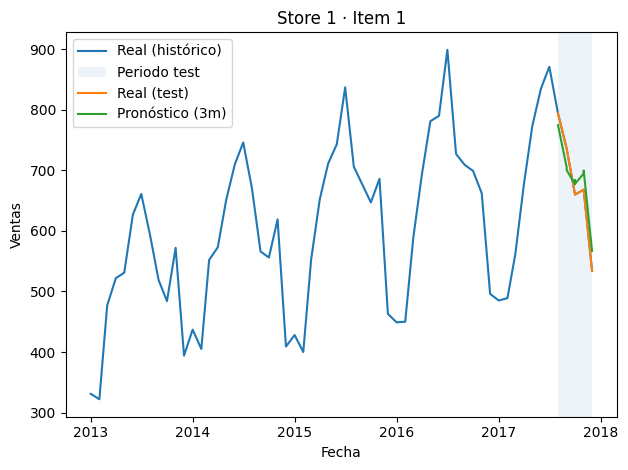

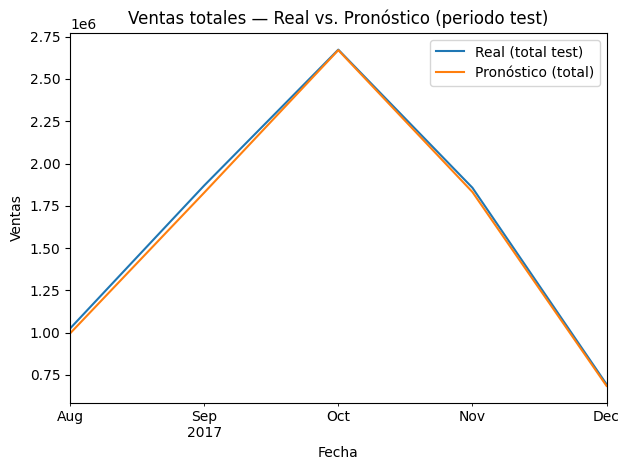

C:\Users\jjcam\AppData\Local\Temp\ipykernel_31100\3935849490.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,store,item,MAE,RMSE
4,1,5,3.894610,4.279284
39,1,40,8.256862,9.793058
300,7,1,10.280500,11.107533
303,7,4,11.840519,12.211998
290,6,41,11.793994,12.722382
219,5,20,10.595898,13.015669
304,7,5,12.569747,13.131617
396,8,47,9.505720,13.228008
450,10,1,10.011627,13.438058
122,3,23,8.969160,13.889138


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

_model = final_model if 'final_model' in globals() else (model if 'model' in globals() else None)
assert _model is not None, "No hay modelo en memoria. Ejecuta las celdas 3–4 o 8."

if 'forecast_df' not in globals():
    assert 'y_pred' in globals(), "Falta forecast_df e y_pred. Corre la celda 5 o 8 para obtener predicciones."
    cols_pred = [f"y_pred_t+{i+1}" for i in range(HORIZON)]
    forecast_df = pd.DataFrame(y_pred, columns=cols_pred)
    if 'y_test' in globals() and y_test is not None and getattr(y_test, "ndim", 1) == 2 and y_test.shape[1] == HORIZON:
        for i in range(HORIZON):
            forecast_df[f"y_true_t+{i+1}"] = y_test[:, i]

for v in ["df","train_months","X_train","X_test","y_test","pairs_index_test","HIST","HORIZON","test_months"]:
    assert v in globals(), f"Falta {v}. Ejecuta la celda 2 (genera secuencias)."

scalers = {}
for (store, item), g in df.groupby(["store","item"]):
    g_train = g[g["date"].isin(train_months)].copy()
    if len(g_train) >= HIST + HORIZON:
        sc = RobustScaler(quantile_range=(5,95))
        sc.fit(g_train[["sales"]].values)
        scalers[(store, item)] = sc

rows = []
assert len(pairs_index_test) == len(forecast_df), "Desalineación entre pairs_index_test y forecast_df."

for i, (store, item, d_end) in enumerate(pairs_index_test):
    sc = scalers.get((store, item))
    if sc is None:
        continue

    horizon_dates = pd.date_range(end=pd.to_datetime(d_end), periods=HORIZON, freq="MS")

    y_pred_sc = forecast_df.iloc[i, :HORIZON].to_numpy()
    y_true_sc = forecast_df.iloc[i, HORIZON:HORIZON*2].to_numpy() if f"y_true_t+{HORIZON}" in forecast_df.columns else None

    y_pred = sc.inverse_transform(y_pred_sc.reshape(-1,1)).ravel()
    y_true = sc.inverse_transform(y_true_sc.reshape(-1,1)).ravel() if y_true_sc is not None else [np.nan]*HORIZON

    for d, yt, yp in zip(horizon_dates, y_true, y_pred):
        rows.append((int(store), int(item), pd.to_datetime(d), float(yt), float(yp)))

forecast_long = (pd.DataFrame(rows, columns=["store","item","date","y_true","y_pred"])
                   .sort_values(["store","item","date"])
                   .reset_index(drop=True))

display(forecast_long.head())

def plot_series_monthly(store_id, item_id):
    g_hist = (df[(df["store"]==store_id) & (df["item"]==item_id)]
                .sort_values("date")[["date","sales"]])
    g_pred = (forecast_long[(forecast_long["store"]==store_id) & (forecast_long["item"]==item_id)]
                .sort_values("date")[["date","y_true","y_pred"]])

    plt.figure()
    plt.plot(g_hist["date"], g_hist["sales"], label="Real (histórico)")
    if not g_pred.empty:
        test_min = g_pred["date"].min(); test_max = g_pred["date"].max()
        plt.axvspan(test_min, test_max, alpha=0.08, label="Periodo test")
        plt.plot(g_pred["date"], g_pred["y_true"], label="Real (test)")
        plt.plot(g_pred["date"], g_pred["y_pred"], label=f"Pronóstico ({HORIZON}m)")
    plt.title(f"Store {store_id} · Item {item_id}")
    plt.xlabel("Fecha"); plt.ylabel("Ventas")
    plt.legend(); plt.tight_layout(); plt.show()

plot_series_monthly(1, 1)

real_total = forecast_long.groupby("date")["y_true"].sum()
pred_total = forecast_long.groupby("date")["y_pred"].sum()

plt.figure()
real_total.plot(label="Real (total test)")
pred_total.reindex(real_total.index).plot(label="Pronóstico (total)")
plt.title("Ventas totales — Real vs. Pronóstico (periodo test)")
plt.xlabel("Fecha"); plt.ylabel("Ventas")
plt.legend(); plt.tight_layout(); plt.show()

def rmse(a,b): 
    return float(np.sqrt(mean_squared_error(a,b)))

err = (forecast_long
       .groupby(["store","item"])
       .apply(lambda g: pd.Series({
           "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
           "RMSE": rmse(g["y_true"], g["y_pred"])
       }))
       .reset_index()
       .sort_values("RMSE"))

display(err.head(10))


In [18]:
import shap
print("SHAP", shap.__version__)

SHAP 0.48.0


# 10. Interpretabilidad

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/50 [00:00<?, ?it/s]

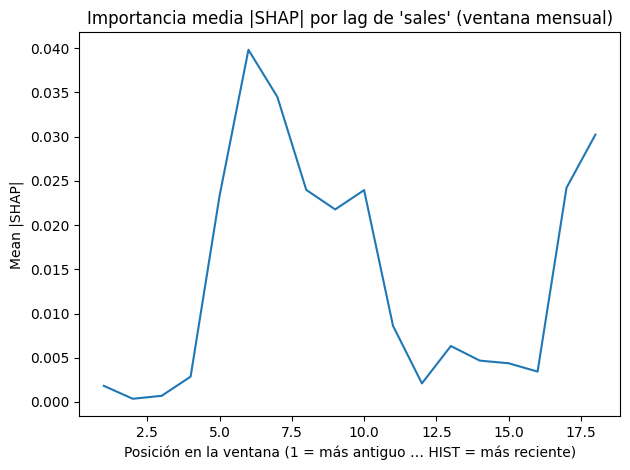

In [19]:

import shap

import matplotlib.pyplot as plt

_model = final_model if 'final_model' in globals() else (model if 'model' in globals() else None)
assert _model is not None, "No hay modelo en memoria. Ejecuta 3–4 o 8."

for v in ["X_train","X_test","HIST"]:
    assert v in globals(), f"Falta {v}. Ejecuta la celda 2 (genera las secuencias)."

n_features = 1 

def predict_from_flat(X_flat):
    X_seq = X_flat.reshape((-1, HIST, n_features))
    yhat = _model.predict(X_seq, verbose=0)  
    return yhat.mean(axis=1)[:, None]        

rng = np.random.default_rng(7)
idx_bg = rng.choice(np.arange(len(X_train)), size=min(200, len(X_train)), replace=False)
idx_ex = rng.choice(np.arange(len(X_test)),  size=min(50,  len(X_test)),  replace=False)

X_bg_flat = X_train[idx_bg].reshape(len(idx_bg), -1)
X_ex_flat = X_test[idx_ex].reshape(len(idx_ex), -1)

explainer = shap.KernelExplainer(predict_from_flat, X_bg_flat)
shap_values = explainer.shap_values(X_ex_flat, nsamples=200)

sv = shap_values[0] if isinstance(shap_values, list) else shap_values
sv = sv.reshape(len(X_ex_flat), HIST, n_features)[:, :, 0]   # (n, HIST)

lag_importance = np.abs(sv).mean(axis=0)  
lags = np.arange(1, HIST+1)               

plt.figure()
plt.plot(lags, lag_importance)
plt.title("Importancia media |SHAP| por lag de 'sales' (ventana mensual)")
plt.xlabel("Posición en la ventana (1 = más antiguo … HIST = más reciente)")
plt.ylabel("Mean |SHAP|")
plt.tight_layout(); plt.show()

# Task 2 - Teoría

### 1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales? 
El problema del gradiente de fuga en las redes LSTM, es que aunque las LSTM están diseñadas para mitigarlo no son inmunes, ya que en LSTM el estado de la celda va de esta manera:

$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$

Y en la retropropagación a través del tiempo hace que la gradiente hacia:
$$
c_{t-1}
$$

se multiplique por el producto de las compuertas del olvido, entonces el resultado del producto tiende a 0 cuando la secuencia es larga o las compuertas se cierran más, entonces el gradiente se desvanece y si fuera mayor que 1 explotaría. Y eso pasa en la práctuca ya que se puede dar la saturación de sigmoides, sesgo del olvido mal iniciado, secuencias largas y normalización o escala pobre de entradas. Y esto afecta al pronóstico, porque no capta dependencias de largo plazo, tiene predicciones que sub-reaccionan a las señales antiguas, tiene una convergencia lenta y es inestable, ya que a varios pasos el error crece y el modelo olvida el contexto útil.


### 2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso? 

El manejo de estacionalidad en LSTM se puede modelar la estacionalidad como caracteristicas o al quitarla y recomponerla. Ya que, la diferenciación lo que hacec es estabilizar y facilitar el aprendizaje, pero requiere de reintegrar y puede sobreactuar si la estacionalidad no es rígida. En el caso que la estacionalidad sea fuerte o regular es mejor deseasonalizarla, quitarla al entrenar el LSTM sobre la serie limpua y reaplicar al estacionalidad al final. Mientras que si es informativa para el modelo, es mejor agregarlas como features exógenas.



### 3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo? 

El concepto de tamaño de ventana o tambien llamado lookback o W, es cuantos pasos del pasado se le entrega al modelo para predecir el futuro. Y el W si es una ventana corta o pequeña, tiende a patrones de corto plazo, entonces este aprende rápidamente señales locales, pero no ve ciclos largos. Mientras que si es una ventana larga o grande, tiende a patrones de largo plazo, estos pueden capturar tendencias y estacionalidades largas si están presentes en la ventana, tiene parámetros más efectivos, mayor varianza/overfitting, y el entrenamiento es más lengo. Por el desvanecimiento de gradientes si la información útil está muy lejos el LSTM no puede aprovechar todo. Por lo tanto para evaluar el tamaño de la ventana y saber como ajustarla es imporante analizar la serie y su ciclo. Si la H es grande, los datos limitados para evitar W demasiado grandes y si tiene múltiples ciclos. 




